# Multimodal Image and Text Classification Project

## Overview

This project aims to develop a deep learning model that classifies various types of garbage into predefined categories using a combination of image and text data. The architecture combines a Convolutional Neural Network (CNN) for image feature extraction and a DistilBERT model for text feature extraction.

The project uses PyTorch as the deep learning framework, `transformers` for text processing, and is designed to run efficiently on a GPU cluster using Slurm.

## Project Structure
Data can be stored in the following directory or under `/work/TALC/enel645_2024f/garbage_data`

```
├── data/                            # Dataset folder
│   ├── CVPR_2024_dataset_Train      # Training images
│   ├── CVPR_2024_dataset_Val        # Validation images
│   ├── CVPR_2024_dataset_Test       # Test images
├── setup_conda_environment.sh       # Script to set up the conda environment
├── model_notebook.py                # Jupyter notebook for training and evaluating the model
├── train_model.py                   # Python script for training the model (same code as the notebook)
├── README.md                        # This README file
├── slurm_submit_job.sh              # Slurm submission script
└── train_image_descriptions.csv     # CSV file containing captions for training images
```

## Setup Instructions

### Prerequisites

- [Anaconda/Miniconda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) installed.
- Access to a GPU-enabled server or cluster.

### Step 1: Set up Conda Environment

1. **Create and activate the conda environment** using the provided script:

   ```bash
   ./setup_conda_environment.sh
   ```

   This script checks for an existing conda environment named `mm_enel645_assg2`, creates it if it does not exist, and installs all necessary packages.

2. **Verify the installation**:

   ```bash
   conda activate mm_enel645_assg2
   conda list
   ```

### Step 2: Train the Model

1. **Submit the training job to the cluster** using the provided Slurm script:

   ```bash
   sbatch slurm_submit_job.sh
   ```

   This Slurm script (`slurm_submit_job.sh`) allocates the necessary resources (nodes, CPUs, GPUs, memory, etc.) and runs the `train_model.py` script to start training the model.

2. **Monitor the job**:

   You can monitor the Slurm job with:

   ```bash
   squeue -u your_username
   ```

   You can also check the output and error logs using the `.out` and `.err` files generated by Slurm.

### Step 3: Model Evaluation

After training completes, the model will be evaluated on the test set. The results are displayed in a confusion matrix, along with other performance metrics like accuracy, precision, and recall.

## Files Description

- **`setup_conda_environment.sh`**: Bash script to set up the conda environment and install all dependencies.
- **`train_model.py`**: Python script containing all necessary code to train the multimodal model.
- **`slurm_submit_job.sh`**: Slurm batch script for submitting the training job to a cluster.
- **`train_image_descriptions.csv`**: CSV file that contains descriptions/captions for the training images.
- **`README.md`**: This documentation file.

## Requirements

- `torch`: For deep learning model creation.
- `torchvision`: For image data processing.
- `transformers`: For text data processing with DistilBERT.
- `scikit-learn`: For evaluation metrics.
- `matplotlib` and `seaborn`: For plotting confusion matrix and other visualizations.
- `pillow` and `numpy`: For image and numerical data handling.

## Example Usage

1. **Run the training script locally**:

   ```bash
   python train_model.py
   ```

2. **Submit the job to a cluster**:

   ```bash
   sbatch slurm_submit_job.sh
   ```

3. **Check the output** in the Slurm `.out` file to monitor the progress and performance metrics.

## Data and Methods

This project uses a combination of image data and text descriptions to classify images into four categories: Black, Blue, Green, and TTR. The model architecture consists of a ResNet50 model for image feature extraction and a DistilBERT model for processing text descriptions.

### Dataset

- **Image Data**: RGB images of varying resolutions.
- **Text Data**: Generated captions associated with each image.

### Methodology

1. **Data Preprocessing**: Resizing images, tokenizing text, and applying necessary augmentations.
2. **Model**: A multimodal neural network with ResNet50 and DistilBERT components.
3. **Training**: Uses a weighted cross-entropy loss function to account for class imbalance.
4. **Evaluation**: Performance metrics like accuracy, precision, recall, and confusion matrix are computed.

## Contact Information

For any questions or issues, please reach out to `muhammad.mahajna@ucalgary.ca`.

## License

This project is licensed under the MIT License - see the LICENSE file for details.


In [1]:
# Importing necessary libraries for building and training models, handling data, and visualizations

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Define device preference order: CUDA if available, MPS if available (for Apple Silicon), otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')


Using device: mps


Using base directory: ../../data/enel645_2024f/garbage_data
Black: Weight: 0.2662
Blue: Weight: 0.1291
Green: Weight: 0.2823
TTR: Weight: 0.3224


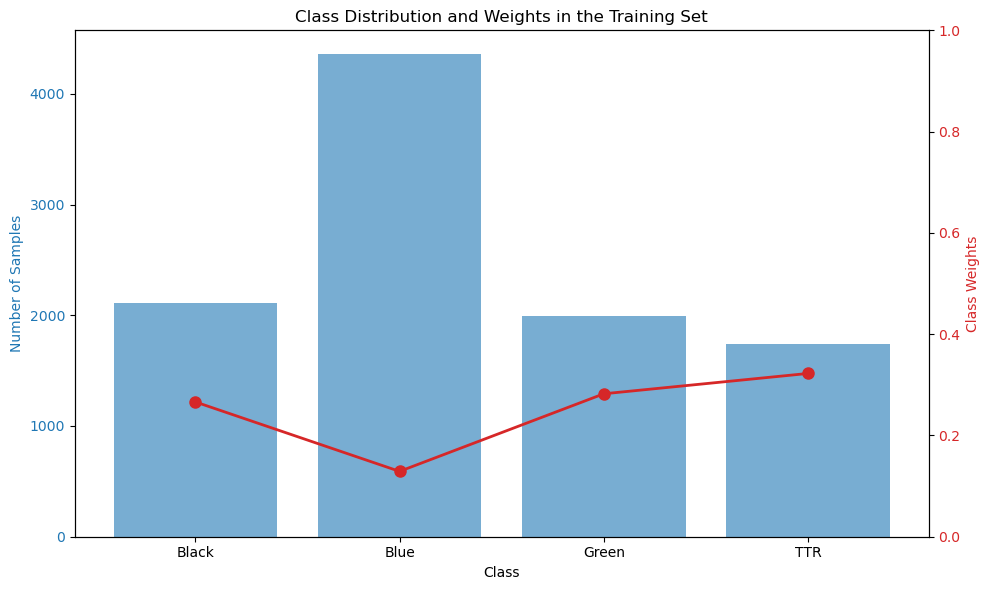

In [2]:
# Data preparation

# Label map - Converts class names to corresponding integer labels for training purposes
label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}

# General function to extract text description from filenames
def extract_text_from_filename(filename):
    file_name_no_ext, _ = os.path.splitext(filename)
    # Remove trailing numbers and replace underscores with spaces
    return re.sub(r'\d+', '', file_name_no_ext.replace('_', ' '))

# Load data - Given a data directory, this function loads images and extracts labels based on folder names
def load_data(data_dir, label_map, file_extensions=('.png', '.jpg', '.jpeg')):
    image_paths, texts, labels = [], [], []

    # Iterate through each class label and corresponding index
    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue

        # Iterate through all files in the class folder
        for filename in os.listdir(folder_path):
            # Select only image files with specified extensions
            if filename.lower().endswith(file_extensions):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)
                texts.append(extract_text_from_filename(filename))
                labels.append(label_idx)

    # Return loaded image paths, text descriptions, and labels as numpy arrays
    return np.array(image_paths), np.array(texts), np.array(labels)

# Function to detect the base directory based on whether it's running on a local machine or TALC cluster
def detect_base_directory():
    possible_dirs = [
        r"/work/TALC/enel645_2024f/garbage_data",  # Directory on TALC cluster
        r"../../data/enel645_2024f/garbage_data"   # Directory on LAPTOP - relative path
    ]

    for base_dir in possible_dirs:
        if os.path.exists(base_dir):
            print(f"Using base directory: {base_dir}")
            return base_dir

    # Raise an error if no valid data directory is found
    raise ValueError("No valid base directory found.")

# Define the custom dataset class to handle multimodal data (images + text descriptions)
from torch.utils.data import Dataset
from PIL import Image
import torch

class MultimodalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None, tokenizer=None, max_len=24):
        """
        Custom Dataset to handle multimodal inputs (image and text).
        
        Args:
            image_paths (list): List of file paths to the images.
            texts (list): List of text descriptions corresponding to the images.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): A function/transform to apply to the images.
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer for text processing.
            max_len (int, optional): Maximum length of tokenized text. Defaults to 24.
        """
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves and processes a single sample from the dataset at the given index.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: A dictionary containing processed image, tokenized text input IDs, attention mask, and label.
        """
        # Load and transform the image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize the text description using the provided tokenizer (e.g., DistilBERT)
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Get the label for the current sample
        label = self.labels[idx]

        # Return a dictionary containing image, input_ids, attention_mask, and label
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    

# Data augmentation and preprocessing transformations for images
def get_image_transforms(image_size=(224, 224)):
    return transforms.Compose([
        transforms.Resize(image_size),          # Resize the image to the specified size
        transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),        # Randomly flip the image vertically
        transforms.RandomRotation(20),          # Randomly rotate the image within 20 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jittering
        transforms.ToTensor(),                  # Convert image to PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean & std
    ])

# Calculate class weights using inverse frequency to handle class imbalance
def calculate_class_weights(train_dir, label_map):
    class_counts = np.zeros(len(label_map), dtype=np.int32)
    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(train_dir, label_name)
        if os.path.isdir(folder_path):
            class_counts[label_idx] = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
    return torch.tensor(class_weights, dtype=torch.float32)

# Usage
base_dir = detect_base_directory()

# Define paths for training, validation, and testing datasets
train_dir = os.path.join(base_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(base_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(base_dir, "CVPR_2024_dataset_Test")

# Load data for training, validation, and testing
train_image_paths, train_texts, train_labels = load_data(train_dir, label_map)
val_image_paths, val_texts, val_labels = load_data(val_dir, label_map)
test_image_paths, test_texts, test_labels = load_data(test_dir, label_map)

# Get image transformations and tokenizer
transform = get_image_transforms(image_size=(224, 224))
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_dataset = MultimodalDataset(train_image_paths, train_texts, train_labels, transform=transform, tokenizer=tokenizer)
val_dataset = MultimodalDataset(val_image_paths, val_texts, val_labels, transform=transform, tokenizer=tokenizer)
test_dataset = MultimodalDataset(test_image_paths, test_texts, test_labels, transform=transform, tokenizer=tokenizer)

# Create DataLoaders with multi-threaded loading
batch_size = 16  # Adjustable based on available memory and system capabilities

nworkers = os.cpu_count()//2
nworkers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nworkers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=nworkers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=nworkers, pin_memory=True)

# Calculate class weights for loss function
class_weights = calculate_class_weights(train_dir, label_map).to(device)

# Print class weights
for class_name, weight in zip(label_map.keys(), class_weights):
    print(f'{class_name}: Weight: {weight:.4f}')

# Plotting class distribution and weights for visualization
class_names = list(label_map.keys())
class_counts = np.array([len(os.listdir(os.path.join(train_dir, name))) for name in class_names])

# Plotting the class distribution and weights
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for class counts
color = 'tab:blue'
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples', color=color)
ax1.bar(class_names, class_counts, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for class weights
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Class Weights', color=color)
ax2.plot(class_names, class_weights.cpu().numpy(), color=color, marker='o', linestyle='-', linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

# Add plot title
plt.title('Class Distribution and Weights in the Training Set')

# Show plot
plt.tight_layout()
plt.show()

# As seen in the following plot, there is a significant imbalance in class distributions, 
# as shown by the Blue class having almost double the number of samples compared to other classes, 
# using class weights is crucial to prevent the model from being biased towards the majority class.


In [3]:

# Define the multimodal model combining ResNet50 and DistilBERT
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        # Load pretrained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove the classification layer of ResNet50
        self.resnet_feature_dim = 2048  # ResNet50 output feature dimension

        # Load DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.distilbert_feature_dim = 768  # DistilBERT output feature dimension

        # Fully connected layers for combining features
        self.fc = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.distilbert_feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),  # 30% dropout to reduce overfitting
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Extract image features using ResNet50
        image_features = self.resnet(images)

        # Extract text features using DistilBERT
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output

# Hyperparameters and model setup
num_classes = len(label_map)
learning_rate = 2e-5

# Instantiate model and move to device
model = MultimodalModel(num_classes=num_classes).to(device)

# Define loss function with class weights to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Define learning rate scheduler with exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [4]:
# Training loop with early stopping
best_val_loss = float('inf')    # start with a very high value (infinity)
patience = 5                    # How many epochs without improvement to allow
epochs_no_improve = 0           # Counter for epochs with no improvement
num_epochs = 10                 # Maximum number of training epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        # Move batch data to device (with pin_memory enabled in DataLoader)
        images = batch['image'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: Calculate model predictions for the current batch
        outputs = model(images, input_ids, attention_mask)

        # Calculate the cross-entropy loss between predictions and true labels
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients with respect to the model parameters
        loss.backward()

        # Update the model parameters using the computed gradients
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()
    
    # Normalize train_loss by the number of batches
    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()  # Change state to validation mode
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():  # Stop calculating gradients during validation
        for batch in val_loader:
            # Move batch data to device
            images = batch['image'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)

            # Forward pass: Calculate model predictions for the current batch
            outputs = model(images, input_ids, attention_mask)
            
            # Calculate validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get the index of the maximum log-probability as the prediction
            _, preds = torch.max(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Normalize the validation loss by the number of batches
    val_loss /= len(val_loader)

    # Calculate statistical metrics on the entire validation set
    val_accuracy = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted')
    val_recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.4f}, Val Prec: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

    # Update the learning rate (exponential decay, gamma=0.9)
    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), f'best_multimodal_model.pth')  # Save the best model with epoch info
        best_val_loss = val_loss  # Update best validation loss value
        epochs_no_improve = 0  # Reset the counter
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered. Restoring the best model...")
            model.load_state_dict(torch.load('best_multimodal_model.pth'))  # Restore best model
            break


Epoch [1/10], Train Loss: 0.6339, Val Loss: 0.3729, Val Acc: 0.8639, Val Prec: 0.8679, Val Recall: 0.8639
Validation loss improved (inf → 0.3729). Saving model...
Epoch [2/10], Train Loss: 0.3585, Val Loss: 0.3643, Val Acc: 0.8739, Val Prec: 0.8795, Val Recall: 0.8739
Validation loss improved (0.3729 → 0.3643). Saving model...
Epoch [3/10], Train Loss: 0.2802, Val Loss: 0.3175, Val Acc: 0.8933, Val Prec: 0.8953, Val Recall: 0.8933
Validation loss improved (0.3643 → 0.3175). Saving model...
Epoch [4/10], Train Loss: 0.2272, Val Loss: 0.3329, Val Acc: 0.8939, Val Prec: 0.8959, Val Recall: 0.8939
Epoch [5/10], Train Loss: 0.1901, Val Loss: 0.3616, Val Acc: 0.8822, Val Prec: 0.8868, Val Recall: 0.8822
Epoch [6/10], Train Loss: 0.1621, Val Loss: 0.3644, Val Acc: 0.8872, Val Prec: 0.8920, Val Recall: 0.8872
Epoch [7/10], Train Loss: 0.1461, Val Loss: 0.3498, Val Acc: 0.8989, Val Prec: 0.9013, Val Recall: 0.8989
Epoch [8/10], Train Loss: 0.1262, Val Loss: 0.3876, Val Acc: 0.8967, Val Prec: 0.

FileNotFoundError: [Errno 2] No such file or directory: 'best_multimodal_model_epoch_{epoch+1}.pth'

In [5]:
# Load the model and evaluate on the test set. Steps are similar to the validation phase
# Before running this cell, make sure that the '# DL Model' cell was properly executed

# Load the best model weights
model.load_state_dict(torch.load('best_multimodal_model.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Initialize variables for collecting results
test_predictions = []
test_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Get model predictions
        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        # Store predictions and true labels for metric calculation
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


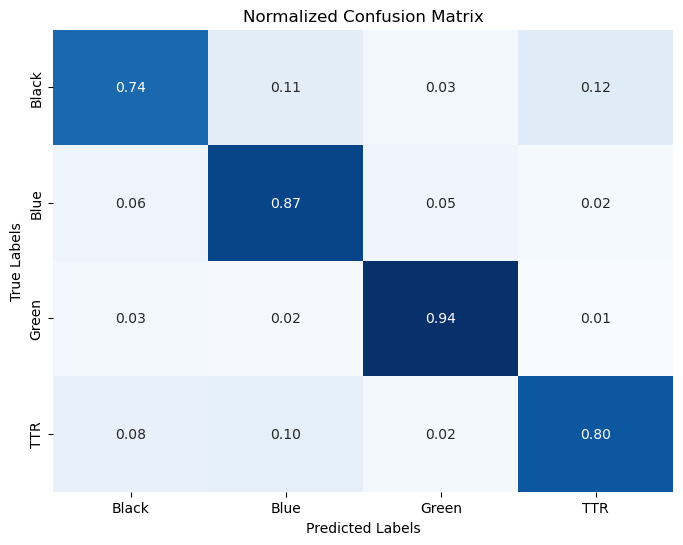

Test Accuracy: 0.8435, Test Precision: 0.8425, Test Recall: 0.8435, Test F1 Score: 0.8424
Accuracy for Black: 0.7396
Accuracy for Blue: 0.8710
Accuracy for Green: 0.9424
Accuracy for TTR: 0.8005


In [6]:
# Statistical analysis of the test set
# Make sure the '# Data preparation' cell was executed before running this cell

# Confusion matrix calculation
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by the number of actual samples in each class (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate overall test set metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')  # Calculate weighted F1 score

print(f'Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}')

# Calculate the accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Map label indices back to class names
label_names = {v: k for k, v in label_map.items()}

# Print accuracy per class
for i, accuracy in enumerate(class_accuracy):
    class_name = label_names[i]
    print(f'Accuracy for {class_name}: {accuracy:.4f}')


Number of cases where "Other" was mistakenly identified as "Blue": 83
Indices of the mistakes: [9, 19, 22, 28, 33, 38, 62, 68, 83, 84, 105, 106, 116, 125, 133, 153, 167, 176, 183, 187, 210, 213, 215, 218, 234, 257, 272, 274, 293, 296, 297, 304, 314, 330, 331, 332, 337, 353, 360, 373, 374, 379, 384, 393, 409, 411, 420, 424, 435, 453, 455, 465, 480, 483, 497, 499, 500, 522, 538, 540, 546, 554, 568, 575, 577, 581, 582, 590, 593, 594, 597, 608, 611, 639, 643, 646, 650, 651, 652, 669, 675, 692, 694]


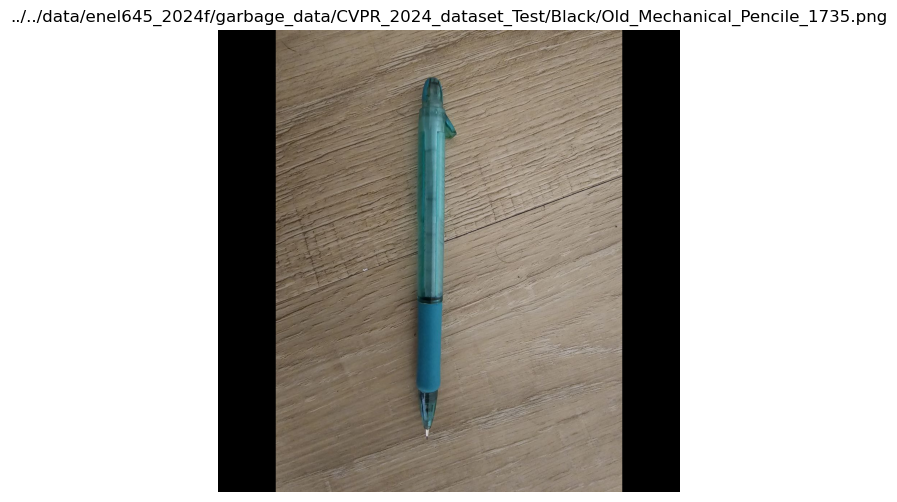

Old Mechanical Pencile 


In [9]:
mistaken_indices = [i for i, (true, pred) in enumerate(zip(test_labels, test_predictions)) if true == 0 and pred == 3]
print(f'Number of cases where "Other" was mistakenly identified as "Blue": {len(mistaken_indices)}')
print("Indices of the mistakes:", mistaken_indices)

# keywords: plastic, bottle, Container, box, packaging, bag, wrapper
# Load the image
#print(test_image_paths[mistaken_indices])

ind = mistaken_indices[1]
image_path = test_image_paths[ind]

image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.title(image_path)
plt.show()

print(test_texts[ind])